In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import math
import random

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

Using device: cuda


In [4]:
def get_state(curr_state, drift, days, action):
    """
    Calculate the next state based on the current state and drift.
    """
    if action==1:
        return 2*drift*days+1
    delta = random.uniform(-drift, drift)
    return max(0, min(curr_state + delta, 2 * days * drift))

In [5]:
def get_reward(curr_state, action, days, drift, start_price, strike_price):
    """
    Calculate the reward based on the current state and action.
    """
    if action == 0:
        return 0
    else:
        return curr_state - days * drift + start_price - strike_price

In [6]:
class OptionPricingNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super(OptionPricingNetwork, self).__init__()

        # Input layer
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.input_activation = nn.LeakyReLU()

        # Hidden layers
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden_layers):
            layer = nn.Linear(hidden_size, hidden_size)
            self.hidden_layers.append(layer)
            self.hidden_layers.append(nn.LeakyReLU())

        # Output layer
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, state):
        x = self.input_layer(state)
        x = self.input_activation(x)
        
        for layer in self.hidden_layers:
            x = layer(x)
        
        x = self.output_layer(x)
        return x

In [7]:
# Define the input and output sizes
input_size = 2 # Size of your state representation
output_size = 2  # Number of actions (exercise or not exercise)

In [8]:
# Create the main and target networks
hidden_size = 64  # Example hidden layer size
num_hidden_layers = 2  # Example number of hidden layers

# Create the main and target networks and move them to GPU
main_network = OptionPricingNetwork(input_size, hidden_size, output_size, num_hidden_layers).to(device)
target_network = OptionPricingNetwork(input_size, hidden_size, output_size, num_hidden_layers).to(device)
target_network.load_state_dict(main_network.state_dict())


# Define the optimizer and loss function
optimizer = optim.Adam(main_network.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()

In [9]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = []
        self.capacity = capacity
        self.position = 0

    def push(self, args):
        """Saves a transition to the replay buffer."""
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = args
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        """Returns a random sample of transitions from the replay buffer."""
        batch = random.sample(self.buffer, batch_size)
        return batch
        # state, time, action, reward, next_state, done = zip(*batch)
        # return Transition(state, time, action, reward, next_state, done)

    def __len__(self):
        return len(self.buffer)

In [10]:
buffer_size=1000
batch_size=216
start_states=[]
loss_arr=[]
reward_arr=[]
replay_buffer = ReplayBuffer(buffer_size)

In [11]:
T = 10  # Number of time steps
drift = 10
start_price = 500
strike_price = 505

In [12]:
# Modify input data generation to move to GPU
def dqn_learning(days=T, drift=drift, start_price=500, strike_price=510, df=0.99, num_iter=50000):
    epsilon = 1
    epsilon_decay = 0.995
    epsilon_min = 0.01
    steps=0
    target_update_interval = 8

    for ep in range(num_iter):
        if ep % 1000 == 0:
            print(ep)

        curr_state =int (ep % (2 * days * drift + 1))
        # start_states.append(curr_state)
        reward_curr = 0
        time= np.random.randint(0, days)
        start_states.append((curr_state,time))

        done=0
        while done == 0:
            # Select an action using epsilon-greedy exploration
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.choice([0, 1])
            else:
                # Move input data to GPU
                state_tensor = torch.from_numpy(np.array([curr_state, time], dtype=np.float32)).to(device)
                action = main_network(state_tensor.unsqueeze(0)).argmax().item()
            
            next_state = get_state(curr_state, drift, days, action)
            
            reward = get_reward(curr_state, action, days, drift, start_price, strike_price)
            if time==days or action==1:
                done=1

            # Store the experience tuple in the replay buffer
            replay_buffer.push([curr_state, time, action, reward, next_state, done])

            # Sample a batch of experience tuples from the replay buffer
            if len(replay_buffer.buffer) >= batch_size:
                batch = replay_buffer.sample(batch_size)
                state_batch, time_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)
                # Move batch data to GPU
                state_batch = torch.tensor(state_batch, dtype=torch.float32).to(device)
                time_batch = torch.tensor(time_batch, dtype=torch.float32).to(device)
                action_batch = torch.tensor(action_batch, dtype=torch.int64).to(device)
                reward_batch = torch.tensor(reward_batch, dtype=torch.float32).to(device)
                next_state_batch = torch.tensor(next_state_batch, dtype=torch.float32).to(device)
                done_batch = torch.tensor(done_batch, dtype=torch.float32).to(device)

                # Compute Q-values for current and next states
                current_q_values = main_network(torch.stack((state_batch, time_batch), dim=1))
                current_q_values = current_q_values.gather(1, action_batch.unsqueeze(1))
                with torch.no_grad():
                    next_q_values = target_network(torch.stack((next_state_batch, time_batch + 1), dim=1))
                    next_q_values = next_q_values.max(1)[0].detach()
                    next_q_values[done_batch == 1] = 0  # Zero out Q-values for terminal states

                target_q_values = reward_batch + df * next_q_values
                # Compute loss and backpropagation
                optimizer.zero_grad()
                loss = loss_fn(current_q_values.squeeze(), target_q_values)
                loss_arr.append(loss.item())
                loss.backward()
                optimizer.step()

            # Update the target network's weights periodically
            if steps % target_update_interval == 0:
                target_network.load_state_dict(main_network.state_dict())

            curr_state = next_state
            reward_curr += reward * math.pow(df, time - start_states[-1][1])
            time += 1
            steps += 1

        reward_arr.append(reward_curr)
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

    return reward_arr

In [ ]:
reward_arr = dqn_learning()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000


In [24]:
def find_policy(model, drift, start_price, strike_price, T):
    policy = {}  # Dictionary to store policy for each price

    for time in range(T):
        time_policy = []  # Policy for current price
        for price in range(2 * T * drift + 1):
            # Move input data to GPU
            state = torch.tensor([price, time], dtype=torch.float32).to(device)
            action = model(state.unsqueeze(0))
            # Append the index of the action with maximum Q-value to the policy
            time_policy.append(action.argmax().item())
        policy[time] = time_policy
    
    return policy

# Find policy
policy = find_policy(main_network, drift, start_price, strike_price, T)

# Print policy for each price
for price, price_policy in policy.items():
    print(f"Price: {price}, Policy: {price_policy}")


Price: 0, Policy: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Price: 1, Policy: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [25]:
import torch

def find_threshold(model, drift, start_price, strike_price, T):
    thresholds = []  # List to store thresholds for each time

    for time in range(T):
        # Binary search to find the threshold
        left = torch.tensor(0.0, dtype=torch.float32, device=device)
        right = torch.tensor(start_price + 2 * T * drift, dtype=torch.float32, device=device)
        while (right - left) >= 0.01:
            mid = (left + right) / 2
            state = torch.tensor([mid, time], dtype=torch.float32, device=device).unsqueeze(0)
            action_probs = model(state)
            if action_probs.argmax().item() == 1:
                right = mid
            else:
                left = mid
        thresholds.append(left - T * drift + start_price)
    return thresholds


In [26]:
optimal_policy = find_threshold(main_network, 10, 500, 505, 10)
print(optimal_policy)

[tensor(523.4207, device='cuda:0'), tensor(523.0789, device='cuda:0'), tensor(521.7758, device='cuda:0'), tensor(520.0081, device='cuda:0'), tensor(517.8452, device='cuda:0'), tensor(516.7823, device='cuda:0'), tensor(515.6876, device='cuda:0'), tensor(514.4966, device='cuda:0'), tensor(513.3057, device='cuda:0'), tensor(512.2002, device='cuda:0')]


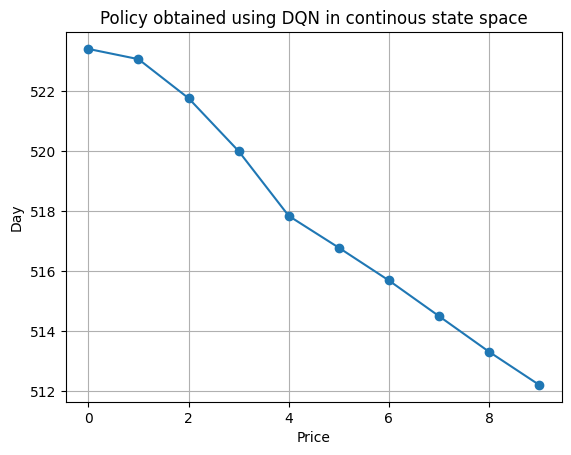

In [39]:
# optimal_policy = []
# for day, action in policy.items():
#     for i in reversed(range(len(action))):
#         if(action[i]==0):
#             optimal_policy.append(i - T*drift + start_price + 1)
#             print("Day ",day+1,": ",i-T*drift+start_price+1)
#             break

# Extract the first value from each tensor
values = [tensor.item() for tensor in optimal_policy]

# Create x-axis values (indices of tensors)
x_values = list(range(len(values)))

# Plotting
plt.plot(x_values, values, marker='o')
plt.xlabel('Price')
plt.ylabel('Day')
plt.title('Policy obtained using DQN in continous state space')
plt.grid(True)
plt.show()

In [28]:
# plt.plot(optimal_policy, marker='o')  # Plotting every 100th value
# plt.title('Optimal Policy: Threshold Price vs Days (By DQN)')
# plt.xlabel('Days')
# plt.ylabel('Threshold Price')
# plt.grid(True)  # Add grid
# plt.show()

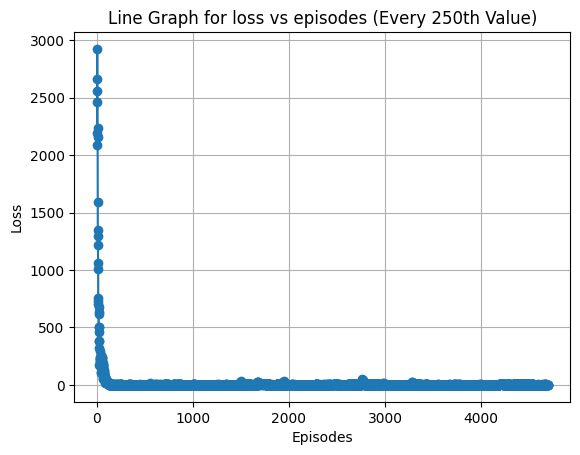

In [29]:
plt.plot(loss_arr[::45], marker='o')  # Plotting every 100th value
plt.title('Line Graph for loss vs episodes (Every 250th Value)')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.grid(True)  # Add grid
plt.show()

In [30]:
def transition_probability(drift):
    """
    Calculates the transition probability for the given drift.
    """
    return 1 / (2 * drift + 1)

def get_state(drift):
    """
    Generates a random state within the given drift range.
    """
    return np.random.randint(-drift, drift, dtype=int) 

def value_iteration(gamma=0.99):
    """
    Performs value iteration to find the optimal policy.
    """
    start_price, strike_price = 500, 505
    drift = 10  # Change in stock price on each day
    T = 10  # Number of days till expiry

    V = np.zeros((2 * T * drift + 1, T))
    policy = np.zeros((T, 2 * T * drift + 1))

    # Initialize the value function and policy
    for state in range(2 * T * drift + 1):
        V[state][T - 1] = max(0, state - (strike_price - start_price) - T * drift)
        if V[state][T - 1] > 0:
            policy[T - 1][state] = 1

    # Perform value iteration
    for t in reversed(range(T - 1)):
        Q = np.zeros((2 * T * drift + 1, 2))
        for state in range(2 * T * drift + 1):
            for action in [0, 1]:
                new_value = 0.0
                if action == 0:
                    reward = 0
                    for next_state in range(state - drift, state + drift):
                        if 0 <= next_state <= 2 * T * drift:
                            new_value += transition_probability(drift) * (reward + gamma * V[next_state][t + 1])
                else:
                    reward = state - (strike_price - start_price) - T * drift
                    new_value = reward
                Q[state][action] = new_value
            V[state][t] = max(Q[state])
            # Update policy based on Q values
            if Q[state][0] >= Q[state][1]:
                policy[t][state] = 0
            else:
                policy[t][state] = 1
    optimal = []
    for t in range(T):
        for i in reversed(range(2 * T * drift + 1)):
            if policy[t][i] == 0:
                optimal.append(i - T * drift + start_price)
                break
    plt.plot(optimal)
    plt.title('Optimal Policy: Threshold Price vs Days (By Value Iteration)')
    plt.xlabel('Days')
    plt.ylabel('Threshold Price')
    plt.grid(True)  # Add grid
    plt.show()
    return V

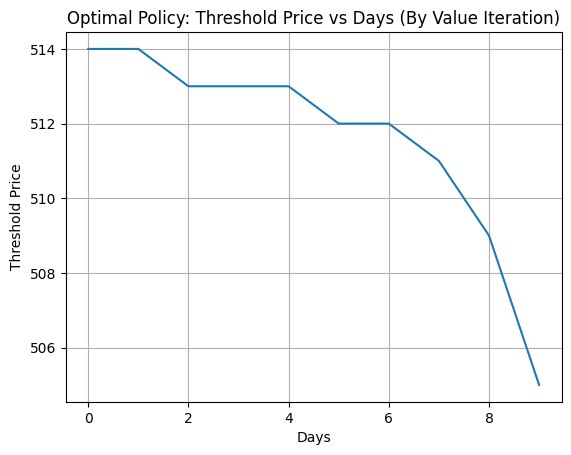

In [31]:
V = value_iteration()

In [32]:
regrets=[]
for i in range(0,len(start_states)):
    regrets.append(V[start_states[i]] - reward_arr[i])


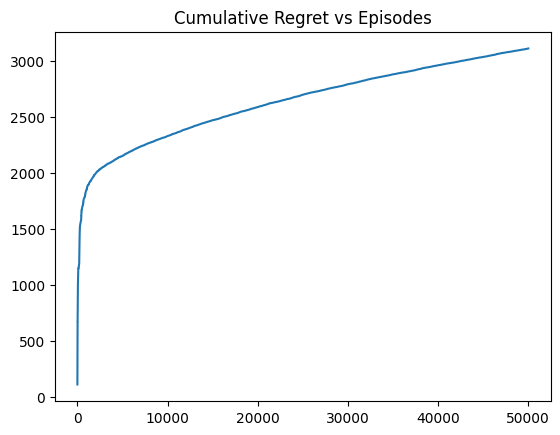

In [34]:
import math
arr_tot = []
for i in range(len(regrets)):
    if(i==0):
        arr_tot.append(regrets[i])
    else:
        arr_tot.append(arr_tot[-1]+regrets[i])
plt.plot(arr_tot)
plt.title("Cumulative Regret vs Episodes")
plt.show()

In [36]:
regrets = regrets[::10]

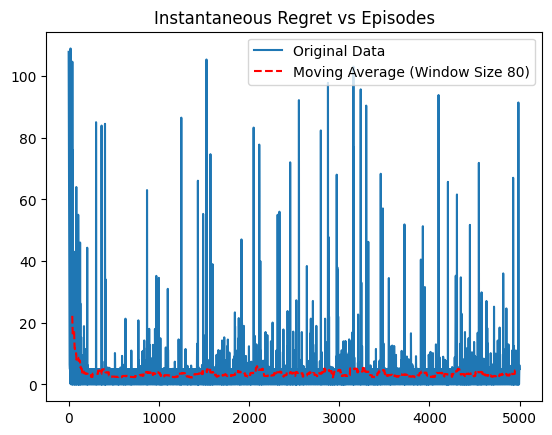

In [38]:
regrets = np.array(regrets)
regrets = abs(regrets)
# Calculate the moving average using a window size (you can adjust the window size as needed)
window_size = 80
moving_avg = np.convolve(regrets, np.ones(window_size)/window_size, mode='valid')

# Adjusting indices to match the length of moving average
indices = range(window_size//2, len(moving_avg) + window_size//2)

# Plotting the original data
plt.plot(regrets, label='Original Data')

# Plotting the moving average
plt.plot(indices, moving_avg, label=f'Moving Average (Window Size {window_size})', linestyle='--', color='red')

plt.title("Instantaneous Regret vs Episodes")
plt.legend()
plt.show()
